In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial
import cartopy
import cartopy.crs as ccrs

from external_datasets import load_external_datasets

In [3]:
crs_3031 = cartopy.crs.Stereographic(central_latitude=-90, true_scale_latitude=-71)
crs_lonlat = cartopy.crs.PlateCarree()

In [4]:
df_tmp = pd.read_csv('data_preprocessing/snr_data_cresis_antarctica.csv')[::10]
ds_cresis = xr.Dataset.from_dataframe(df_tmp)
ds_cresis

<xarray.Dataset> Size: 27MB
Dimensions:          (index: 552886)
Coordinates:
  * index            (index) int64 4MB 0 10 20 30 ... 5528830 5528840 5528850
Data variables:
    x                (index) float64 4MB 2.523e+06 2.523e+06 ... 2.985e+05
    y                (index) float64 4MB -7.987e+05 -7.987e+05 ... 3.549e+04
    snr              (index) float64 4MB -2.399 0.0 0.0 ... -2.869 -4.399 -2.891
    source_csv_file  (index) object 4MB 'Data_20191029_01_003.csv' ... 'Data_...
    source_mat_file  (index) object 4MB 'Data_20191029_01_003.mat' ... 'Data_...

In [5]:
ds_bm_ais = xr.load_dataset("external_datasets/BedMachineAntarctica-v3.nc")
ds_bm_gis = xr.load_dataset("external_datasets/BedMachineGreenland-v5.nc")

In [6]:
ds_bm_ais

<xarray.Dataset> Size: 4GB
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 53kB -3333000 -3332500 -3332000 ... 3332500 3333000
  * y          (y) int32 53kB 3333000 3332500 3332000 ... -3332500 -3333000
Data variables:
    mapping    |S1 1B b''
    mask       (y, x) int8 178MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    firn       (y, x) float32 711MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    surface    (y, x) float32 711MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    thickness  (y, x) float32 711MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bed        (y, x) float32 711MB -5.916e+03 -5.92e+03 ... -3.664e+03
    errbed     (y, x) float32 711MB nan nan nan nan nan ... nan nan nan nan nan
    source     (y, x) int8 178MB 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    dataid     (y, x) int8 178MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    geoid      (y, x) int16 356MB -1 -1 -1 -1 -1 -1 ... -19 -19 -19 -19 -19 -19
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [7]:
ds_cresis

<xarray.Dataset> Size: 27MB
Dimensions:          (index: 552886)
Coordinates:
  * index            (index) int64 4MB 0 10 20 30 ... 5528830 5528840 5528850
Data variables:
    x                (index) float64 4MB 2.523e+06 2.523e+06 ... 2.985e+05
    y                (index) float64 4MB -7.987e+05 -7.987e+05 ... 3.549e+04
    snr              (index) float64 4MB -2.399 0.0 0.0 ... -2.869 -4.399 -2.891
    source_csv_file  (index) object 4MB 'Data_20191029_01_003.csv' ... 'Data_...
    source_mat_file  (index) object 4MB 'Data_20191029_01_003.mat' ... 'Data_...

In [8]:
def interpolate_nearest_from_grid(ds_source, ds_target, field_name, x_name='x', y_name='y'):
    """
    Interpolate a gridded field from ds_source to ungridded points in ds_target using nearest neighbor.

    Parameters:
        ds_source (xr.Dataset): Gridded source dataset
        ds_target (xr.Dataset): Ungridded target dataset with x/y coordinates
        field_name (str): Name of the variable to interpolate from ds_source
        x_name (str): Name of x-coordinate in both datasets
        y_name (str): Name of y-coordinate in both datasets

    Returns:
        xr.DataArray: Interpolated field with same coords/dims as ds_target
    """
    # Extract gridded source coordinates and field
    X_src, Y_src = np.meshgrid(ds_source[x_name].values, ds_source[y_name].values)
    Z_src = ds_source[field_name].values

    # Flatten for KDTree
    source_points = np.column_stack((X_src.ravel(), Y_src.ravel()))
    source_values = Z_src.ravel()

    # Extract scattered target coordinates
    x_tgt = ds_target[x_name].values
    y_tgt = ds_target[y_name].values
    target_points = np.column_stack((x_tgt, y_tgt))

    # Build KDTree and query nearest neighbors
    tree = scipy.spatial.cKDTree(source_points)
    _, idx = tree.query(target_points, k=1)
    interpolated_values = source_values[idx]

    #return interpolated_values

    # Return as DataArray aligned with ds_target
    return xr.DataArray(
        interpolated_values,
        coords={'index': ds_target.index},
        #dims=ds_target[field_name].dims if field_name in ds_target else (x_name,)
    )

ds_cresis['thickness'] = interpolate_nearest_from_grid(ds_bm_ais, ds_cresis, 'thickness')
ds_cresis['thickness_err'] = interpolate_nearest_from_grid(ds_bm_ais, ds_cresis, 'errbed')
ds_cresis['bm_mask'] = interpolate_nearest_from_grid(ds_bm_ais, ds_cresis, 'mask')
ds_cresis['surface'] = interpolate_nearest_from_grid(ds_bm_ais, ds_cresis, 'surface')

In [9]:
ds_cresis

<xarray.Dataset> Size: 34MB
Dimensions:          (index: 552886)
Coordinates:
  * index            (index) int64 4MB 0 10 20 30 ... 5528830 5528840 5528850
Data variables:
    x                (index) float64 4MB 2.523e+06 2.523e+06 ... 2.985e+05
    y                (index) float64 4MB -7.987e+05 -7.987e+05 ... 3.549e+04
    snr              (index) float64 4MB -2.399 0.0 0.0 ... -2.869 -4.399 -2.891
    source_csv_file  (index) object 4MB 'Data_20191029_01_003.csv' ... 'Data_...
    source_mat_file  (index) object 4MB 'Data_20191029_01_003.mat' ... 'Data_...
    thickness        (index) float32 2MB 0.0 0.0 0.0 ... 3.464e+03 3.464e+03
    thickness_err    (index) float32 2MB nan nan nan nan ... 339.0 330.0 330.0
    bm_mask          (index) int8 553kB 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2
    surface          (index) float32 2MB 0.0 0.0 0.0 ... 3.073e+03 3.073e+03

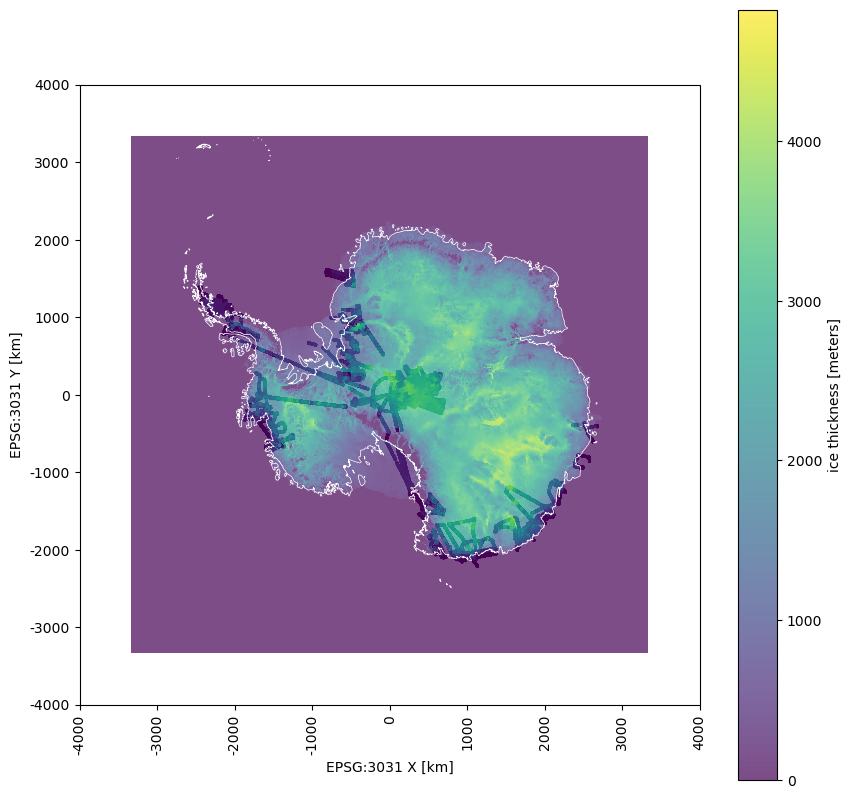

In [10]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=crs_3031))

vmin = np.nanmin(ds_bm_ais['thickness'])
vmax = np.nanmax(ds_bm_ais['thickness'])

ds_bm_ais['thickness'][::10, ::10].plot.pcolormesh(ax=ax, alpha=0.7, vmin=vmin, vmax=vmax)
ax.coastlines(resolution='10m', color='white', linewidth=0.5)

ax.scatter(x=ds_cresis.x, y=ds_cresis.y, c=ds_cresis.thickness, vmin=vmin, vmax=vmax, s=1)

# Axes and coastlines
ax.set_xlabel('EPSG:3031 X [km]')
ax.set_ylabel('EPSG:3031 Y [km]')

ax.set_xticks(ax.get_xticks(), crs=crs_3031)
ax.set_yticks(ax.get_yticks(), crs=crs_3031)
ax.tick_params(axis='x', rotation=90)
# Show axis ticks in kilometers
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))



<xarray.DataArray 'errbed' ()> Size: 4B
array(10., dtype=float32)
<xarray.DataArray 'errbed' ()> Size: 4B
array(0., dtype=float32)


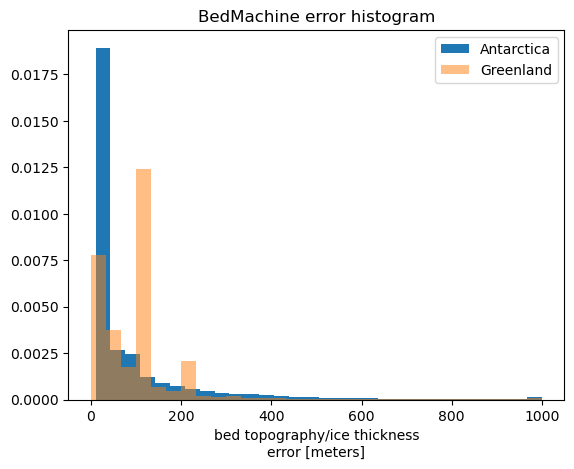

In [14]:
fig, ax = plt.subplots()

ds_bm_ais.errbed.plot.hist(bins=30, density=True, ax=ax, label='Antarctica')
ds_bm_gis.errbed.plot.hist(bins=30, density=True, ax=ax, label='Greenland', alpha=0.5)

print(np.min(ds_bm_ais.errbed))
print(np.min(ds_bm_gis.errbed))

ax.set_title('BedMachine error histogram')
ax.legend()

In [16]:
ds_cresis.to_netcdf('data_preprocessing/snr_data_cresis_ais_with_inputs.nc')